In [1]:
import rebound
import time
import sys
import warnings
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u
from astropy import constants as c

# local imports
import heartbeat
import globs
import metasim

In [2]:
#Yes REBOUND I know I might restore from save...
warnings.filterwarnings("ignore",message="You have to reset function pointers after creating a reb_simulation "
                        "struct with a binary file")
warnings.filterwarnings("ignore",message="File in use for SimulationArchive already exists. "
                        "Snapshots will be appended")

In [3]:
read_only = True

systems = []

def run_sim(filestem='test/test',tmoons=1e4):
    
    # global variables

    globs.initialise()

    globs.glob_dclo = 1. #CE distance to check in rH
    #dir = 'test/'
    globs.glob_archive = ''
    #globals.glob_names = []
    globs.glob_is_close = False

    system = metasim.MetaSim(filestem=filestem,tmoons=tmoons)
    if not read_only:
        system.run_planets()
        if globs.glob_is_close:
            system.rewind()
            system.add_moons()
            system.run_moons()

    system.analyse()
    system.make_timeline()
    
    systems.append(system)

In [4]:
N_sys = 100

for i in range(N_sys):
    run_sim(filestem=f'test/test{i:04d}')


Simulation test/test0000

Restored from save
Planet1 bound to EPIC220208795: a=3.5230961908595093 e=0.502902542515528
Planet2 bound to EPIC220208795: a=1.180344986922353 e=0.25918404013605434
Ganymede1 bound to Planet1: a=0.007337035168043923 e=0.17136403975216613
Callisto1 bound to EPIC220208795: a=13.733965581814209 e=0.7917730476682313
Simulation test/test0001

Restored from save
Planet1 bound to EPIC220208795: a=1.3960080669467134 e=0.19497817817745552
Planet2 bound to EPIC220208795: a=2.7396254556869084 e=0.2945878187802894
Callisto1 bound to Galaxy: a=-13.175694864830719 e=10.547665277591499
Callisto2 bound to EPIC220208795: a=5.2139944159385525 e=0.906670368852637
Simulation test/test0002

Restored from save
Planet2 bound to EPIC220208795: a=1.8412457009567613 e=0.05681211466202166
Europa2 bound to Galaxy: a=-19.00410441266794 e=1.6655199484335637
Simulation test/test0003

Restored from save
Planet1 bound to EPIC220208795: a=0.9668947718004856 e=0.44965196130084445
Planet2 bound

Restored from save
Planet1 bound to EPIC220208795: a=1.8977420885120684 e=0.061527038455778574
Ganymede1 bound to Galaxy: a=-3.4241598687585286 e=46.078610145608614
Callisto1 bound to EPIC220208795: a=14.840129018515373 e=0.8931706422328392
Simulation test/test0024

Restored from save
Planet1 bound to EPIC220208795: a=1.1666432543484413 e=0.39113860113228377
Planet2 bound to EPIC220208795: a=3.5679888668138178 e=0.46572968521436775
Callisto2 bound to Galaxy: a=-224.2747286491967 e=1.0198516034752105
Simulation test/test0025

Restored from save
Planet1 bound to EPIC220208795: a=1.8732839150126093 e=0.06593749923228312
Io1 bound to Planet1: a=0.008908049490261492 e=0.49468132374570606
Simulation test/test0026

Restored from save
Planet1 bound to EPIC220208795: a=3.772694291116392 e=0.4714865658245064
Planet2 bound to EPIC220208795: a=1.26882862250622 e=0.30551554755857147
Europa1 bound to Galaxy: a=-1.6675229762805661 e=45.14958884414147
Europa2 bound to EPIC220208795: a=15.2567775581438

Simulation test/test0047

Restored from save
Planet1 bound to EPIC220208795: a=0.9290935306798427 e=0.5146889794945408
Planet2 bound to EPIC220208795: a=14.026232900427042 e=0.8719530678133465
Io2 bound to Planet2: a=0.004903251127880831 e=0.3962231667141715
Ganymede2 bound to EPIC220208795: a=11.87808369485391 e=0.7889755172609143
Simulation test/test0048

Restored from save
Planet1 bound to EPIC220208795: a=1.319161256384933 e=0.1487937019950446
Planet2 bound to EPIC220208795: a=2.3833292706117146 e=0.2895603732217285
Callisto2 bound to EPIC220208795: a=9.853587125512366 e=0.715986369324705
Simulation test/test0049

Restored from save
Planet1 bound to EPIC220208795: a=7.471079324435083 e=0.7755832444393207
Planet2 bound to EPIC220208795: a=0.9718415989580509 e=0.3861638319408524
Io1 bound to Planet1: a=0.00280932526121563 e=0.12755621399886297
Callisto1 bound to Galaxy: a=-5.99303289257694 e=17.560582696901783
Ganymede2 bound to Planet2: a=0.014212357858406723 e=0.046015243611272454


Restored from save
Planet2 bound to EPIC220208795: a=1.7292688163437717 e=0.05242758846306511
Europa1 bound to Galaxy: a=-110.86114438031275 e=1.462888067796766
Ganymede1 bound to EPIC220208795: a=534.1058702619338 e=0.9743064136636678
Callisto1 bound to Galaxy: a=-7.0997469255181445 e=16.124256546146153
Europa2 bound to Galaxy: a=-1172.9760293099896 e=1.000025571132899
Callisto2 bound to EPIC220208795: a=24.658958659937756 e=0.9143786452899368
Simulation test/test0071

Restored from save
Moons never added
Simulation test/test0072

Restored from save
Planet2 bound to EPIC220208795: a=1.8812946545371483 e=0.06255483921619041
Europa1 bound to Galaxy: a=-10.321960687086511 e=10.704413071068032
Ganymede1 bound to Galaxy: a=-57.07315169628725 e=2.2270794314004014
Callisto2 bound to Galaxy: a=-184.6602335487732 e=1.2738901973167913
Simulation test/test0073

Restored from save
Planet1 bound to EPIC220208795: a=1.0644920362261117 e=0.5830193259981301
Planet2 bound to EPIC220208795: a=8.2502835

Simulation test/test0097

Restored from save
Planet1 bound to EPIC220208795: a=1.8782758995204463 e=0.04560133666185582
Callisto2 bound to Planet1: a=0.0283755800850813 e=0.663289623252964
Simulation test/test0098

Restored from save
Planet1 bound to EPIC220208795: a=1.9292922881395256 e=0.04421254651911088
Europa1 bound to Galaxy: a=-51.5624288260012 e=3.0959289769371354
Callisto1 bound to Galaxy: a=-4.559292315525342 e=13.400856615376915
Europa2 bound to Galaxy: a=-125.45005576831437 e=1.1653985527369437
Simulation test/test0099

Restored from save
Planet1 bound to EPIC220208795: a=1.8324454248417945 e=0.09990313795393144
Ganymede1 bound to Galaxy: a=-1.990928013378243 e=45.95732708451512
Callisto1 bound to Galaxy: a=-61.170277260943465 e=2.326521436512631
Ganymede2 bound to Galaxy: a=-172.36571222588282 e=1.0460779760937726


In [14]:
moon_sims = [s for s in systems if s.has_moons]
N_moon_sims = len(moon_sims)
N_surv_hist = [sum([s.npl == i for s in moon_sims]) for i in (0,1,2)]
print(f"# sims where moons added: {N_moon_sims} out of {N_sys}")
print(f"# sims with [0, 1, 2] surviving planets: {N_surv_hist} "
      f"out of {N_moon_sims}")

# sims where moons added: 90 out of 100
# sims with [0, 1, 2] surviving planets: [0, 30, 60] out of 90


In [6]:
where_1_surv = np.where([s.npl == 1 for s in moon_sims])[0]
where_2_surv = np.where([s.npl == 2 for s in moon_sims])[0]
a = [[o.a for o in [s.orb[p] for p in s.surv_pl]] for s in moon_sims]
e = [[o.e for o in [s.orb[p] for p in s.surv_pl]] for s in moon_sims]
n = [[s.n_debris[p] for p in s.surv_pl] for s in moon_sims]

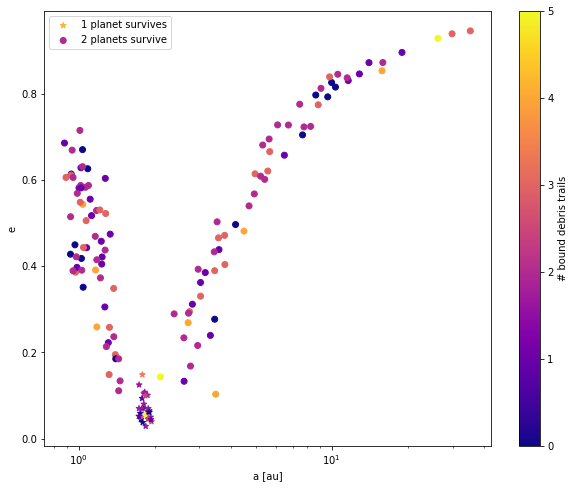

In [54]:
cmap = 'plasma'
plt.figure(figsize=(10,8))
# XXX need to get both sets of points on same colour scale...
plt.scatter([a[w] for w in where_1_surv],[e[w] for w in where_1_surv],c=[n[w] for w in where_1_surv],
            cmap=cmap,marker='*',label='1 planet survives')
plt.scatter([a[w] for w in where_2_surv],[e[w] for w in where_2_surv],c=[n[w] for w in where_2_surv],
            cmap=cmap,marker='o',label='2 planets survive')
plt.xscale('log')
plt.xlabel('a [au]')
plt.ylabel('e')
plt.legend()
plt.colorbar(label='# bound debris trails')
plt.show()

In [16]:
N_debris_1_surv = [n[w] for w in where_1_surv]
N_debris_2_surv = [n[w] for w in where_2_surv]

In [49]:
N_debris_1_surv_hist = [np.sum(np.array(N_debris_1_surv) == i) for i in (0,1,2,3,4,5,6,7,8)]
N_debris_2_surv_hist = [np.sum(np.array(N_debris_2_surv) == i) for i in (0,1,2,3,4,5,6,7,8)]

In [55]:
print(f"{np.sum(N_debris_1_surv_hist[1:])} of {np.sum(N_debris_1_surv_hist)} planets in single-planet systems"
      f"have bound debris")
print(f"np.sum(N_debris_1_surv_hist[1:])} of {np.sum(N_debris_1_surv_hist)} planets in two-planet systems have bound debris")

SyntaxError: f-string: empty expression not allowed (1404983287.py, line 3)